# 循环神经网络
## 序列模型
- 输入、输出或两者都是按特定顺序排列的数据序列；处理这种序列数据的机器学习模型，就叫做序列模型（改变序列中元素的顺序，其含义或结果可能会完全不同）。
### 统计工具
- 自回归模型
    - 策略一：利用当前需要预测的状态前的若干个（有限）状态来训练一个深度网络（一般自回归）；
    - 策略二：保留对过去观测状态的总结，并且同时更新当前状态的预测（基于过去的总结）以及总结（隐变量自回归）；

        ![隐变量自回归](../image/隐变量自回归.jpg)
        - 隐变量序列估值计算方式（连续对象，离散对象的话就会使用分类器来估计）：$P(x_1,\cdots,x_T)=\prod^T_{t=1}P(x_t\mid x_{t-1},\cdots,x_1).$
- 马尔可夫模型
    - 在自回归中，当每次考虑的是当前状态前$k$个状态的话，得到的就是$k$阶马尔可夫模型；
    - 使用动态规划来计算概率结果
    - 计算示例：
        - $$\begin{align*}
            P(x_{t+1} \mid x_{t-1}) &= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})} \\
            &= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})} \\
            &= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
            \end{align*}$$
- 因果关系：就是未来不能改变过去，过去能影响未来。
- 训练示例：

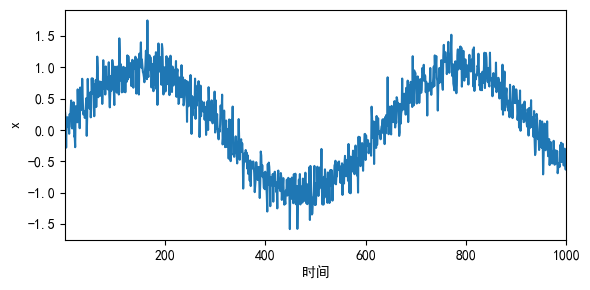

In [1]:

%matplotlib inline
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
"""这里有时绘图失败是因为OpenMP库被多个库加载，Jupyter内核崩溃重启了，加上上面代码允许多个OpenMP库同时加载（临时），实际需要安装同源同系列的库如果涉及到各个不同的库的话"""

"""设置中文字体支持"""
plt.rcParams['font.sans-serif'] = ['SimHei']  # 常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

plt.figure(figsize=(6, 3))
plt.plot(time.numpy(), x.numpy())
plt.xlabel('时间')
plt.ylabel('x')
plt.xlim([1, 1000])

plt.tight_layout()
plt.show()

In [2]:
tau = 4
T = len(x)

features = torch.zeros((T - tau, tau), dtype=torch.float32)

for i in range(tau):
    features[:, i] = x[i: T - tau + i]

labels = x[tau:].reshape((-1, 1))


batch_size, n_train = 16, 600

train_dataset = TensorDataset(features[:n_train], labels[:n_train])
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
from torch import nn


def get_net():
    net = nn.Sequential(
        nn.Linear(tau, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    )
    
    for layer in net:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
    return net

loss = nn.MSELoss()

In [4]:
from torch import optim


def train(net, train_iter, loss, epochs, lr):
    trainer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
            
        total_loss = 0
        count = 0
        with torch.no_grad():
            for X, y in train_iter:
                total_loss += loss(net(X), y).item()
                count += 1
        print(f'epoch {epoch + 1}, loss: {total_loss / count:.6f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.081300
epoch 2, loss: 0.061695
epoch 3, loss: 0.063199
epoch 4, loss: 0.059818
epoch 5, loss: 0.057625
epoch 6, loss: 0.056049
epoch 7, loss: 0.055736
epoch 8, loss: 0.055853
epoch 9, loss: 0.062621
epoch 10, loss: 0.055762


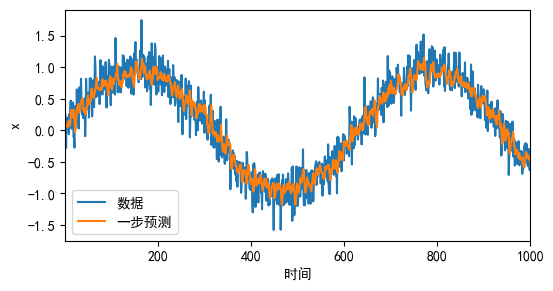

In [5]:
with torch.no_grad():
    onestep_preds = net(features)

plt.figure(figsize=(6, 3))
plt.plot(time.numpy(), x.numpy(), label='数据')
plt.plot(time[tau:].numpy(), onestep_preds.numpy(), label='一步预测')
plt.xlabel('时间')
plt.ylabel('x')
plt.legend()
plt.xlim([1, 1000])
plt.show()

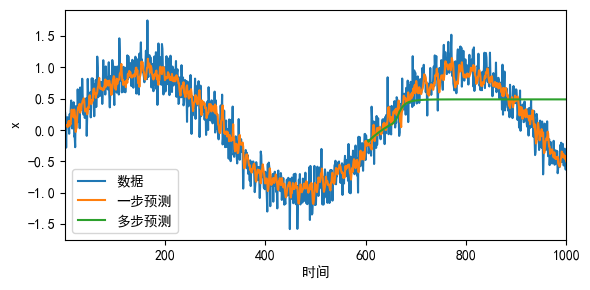

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]

with torch.no_grad():
    for i in range(n_train + tau, T):
        multistep_preds[i] = net(
            multistep_preds[i - tau:i].reshape(1, -1)
        )
        
plt.figure(figsize=(6, 3))
plt.plot(time.numpy(), x.numpy(), label='数据')
plt.plot(time[tau:].numpy(), onestep_preds.detach().numpy(), label='一步预测')
plt.plot(time[n_train + tau:].numpy(), multistep_preds[n_train + tau:].numpy(), label='多步预测')
plt.xlabel('时间')
plt.ylabel('x')
plt.legend()
plt.xlim([1, 1000])
plt.tight_layout()
plt.show()

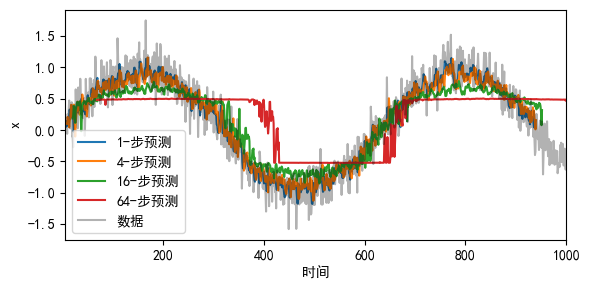

In [7]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

with torch.no_grad():
    for i in range(tau, tau + max_steps):
        features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)

plt.figure(figsize=(6, 3))
for i in steps:
    time_slice = time[tau + i - 1: T - max_steps + i]
    pred_slice = features[:, (tau + i - 1)].numpy()
    plt.plot(time_slice.numpy(), pred_slice, label=f'{i}-步预测')

plt.plot(time.numpy(), x.numpy(), 'k-', alpha=0.3, label='数据')
plt.xlabel('时间')
plt.ylabel('x')
plt.legend()
plt.xlim([5, 1000])
plt.tight_layout()
plt.show()

## 文本预处理
- 就是将原始文本数据转换为计算机可以理解和处理的结构化格式。
    - 简单清晰数据中的一下无关或者错误内容；
    - 分词；
    - 去除停用词；
    - 词干提取或词形还原（英文）；
    - 构建词汇表（词袋）；
    - 数值化表示（词向量）；

In [8]:


def read_time_machine(file_path='../data/timemachine.txt'):
    """将时间机器数据集加载到文本行的列表中"""
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'文本总行数: {len(lines)}')
print(f'第一行: {lines[0]}')
print(f'第十一行: {lines[10]}')

文本总行数: 3221
第一行: the time machine by h g wells
第十一行: twinkled and his usually pale face was flushed and animated the


In [9]:
"""分词器"""
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
        return None

tokens = tokenize(lines)

if tokens:
    for i in range(min(11, len(tokens))):
        print(tokens[i])
else:
    print("分词失败，请检查词元类型参数")

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [10]:


"""词表"""
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """        
        参数:
        tokens: 词元列表，可以是1D或2D列表
        min_freq: 最小频率阈值，低于此频率的词元将被忽略
        reserved_tokens: 保留词元列表（如特殊标记）
        """
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        """按出现频率排序"""
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        """未知词元的索引为0"""
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        """添加满足频率要求的词元"""
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    def __len__(self):
        """返回词表大小"""
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        """
        获取词元的索引
        
        参数:
        tokens: 单个词元或词元列表
        
        返回:
        单个索引或索引列表
        """
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        """
        获取索引对应的词元
        
        参数:
        indices: 单个索引或索引列表
        
        返回:
        单个词元或词元列表
        """
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        """未知词元的索引为0"""
        return 0
    
    @property
    def token_freqs(self):
        """返回词元频率列表"""
        return self._token_freqs

def count_corpus(tokens):
    """统计词元的频率"""
    """这里的tokens是1D列表或2D列表"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        """将词元列表展平成一个列表"""
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [11]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [12]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [13]:
def load_corpus_time_machine(max_tokens=-1):
    """
    返回时光机器数据集的词元索引列表和词表
    
    参数:
    max_tokens: 最大词元数量，-1表示使用所有词元
    
    返回:
    corpus: 词元索引列表
    vocab: 词表对象
    """
    lines = read_time_machine()
    
    tokens = tokenize(lines, 'char')
    
    vocab = Vocab(tokens)
    
    """因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，所以将所有文本行展平到一个列表中"""
    corpus = [vocab[token] for line in tokens for token in line]
    
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 语言模型和数据集
- 关于一个文本序列的概率的计算，基本是考虑使用条件概率的相关计算方式（使用词频来代替估计概率）。
- **拉普拉斯平滑**：解决某些词组出现频率过少的问题
    - 示例（这种做法有个问题就是没考虑词语的含义）：
        $$\begin{align*}
        \hat{P}(x) &= \frac{n(x) + \epsilon_1 / m}{n + \epsilon_1}, \\
        \hat{P}(x' \mid x) &= \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
        \hat{P}(x'' \mid x, x') &= \frac{n(x, x', x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
        \end{align*}$$
这其中$m$是唯一词语的数量，$n$表示训练集中的词语总数，$\epsilon_1,\epsilon_2$和$\epsilon_3$是超参数，其为零时，表示不应用平滑，其接近无穷大时，概率接近均匀概率分布$\frac{1}{m}$。
### 马尔可夫模型与$n$元语法
- 其实这个也就是说，一元语法就是单个词自身概率相乘，二元就是每个词的概率都考虑前一个词所组成的条件概率，三元就是考虑前两个词$\dots$

In [14]:
tokens = tokenize(lines, token='word')
"""因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起"""
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
print(vocab.token_freqs[:10])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


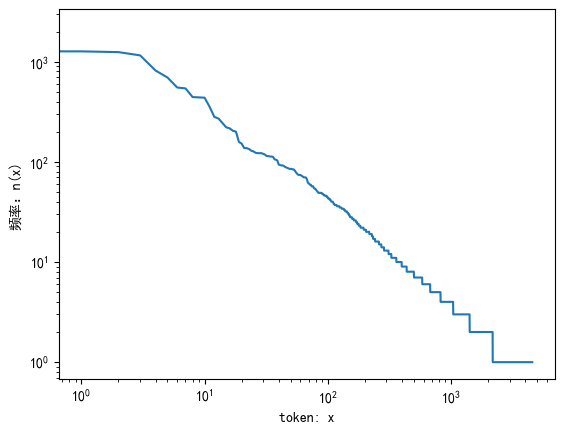

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]

plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('频率：n(x)')
plt.xscale('log')
plt.yscale('log')
plt.show()

- 单纯计数平滑会增加尾部词的频率，从上面的图来看，尾部词是不常用词，所以这种做法不符合实际。上述的表现出实际上词语是满足**奇普夫定律**
    $$n_i\varpropto\frac{1}{i^\alpha}$$
相当于
    $$\log n_i=-\alpha\log i+c$$
其中$\alpha$是刻画分布的指数，$c$是常数。

In [16]:
"""生成二元语法标记（将相邻的两个词组成对）"""
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]

"""创建二元语法的词表"""
bigram_vocab = Vocab(bigram_tokens)

"""显示前10个最频繁的二元语法"""
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [17]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]

trigram_vocab = Vocab(trigram_tokens)

trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

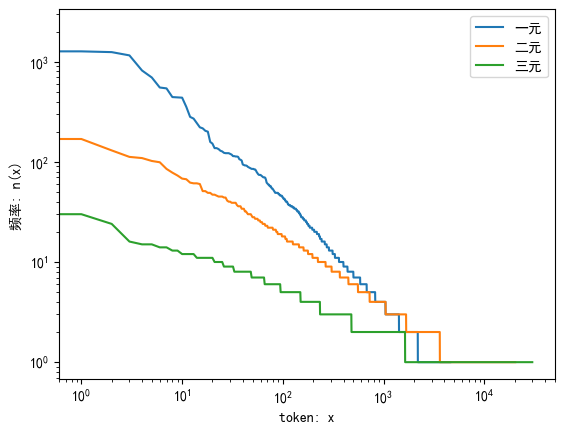

In [18]:
unigram_freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

plt.plot(unigram_freqs, label='一元')
plt.plot(bigram_freqs, label='二元')
plt.plot(trigram_freqs, label='三元')
plt.xlabel('token: x')
plt.ylabel('频率: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

### 读取长序列数据
- **随机采样**
    - 在原始长序列上任意捕获子序列（不一定相邻）；标签就是移位了一个词元的原始序列。

In [19]:

import numpy as np

def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    """从随机偏移量开始"""
    start_idx = random.randint(0, num_steps - 1)
    corpus = corpus[start_idx:]
    
    """计算子序列数"""
    num_subseqs = (len(corpus) - 1) // num_steps
    
    """生成并打乱起始索引"""
    start_indices = np.arange(0, num_subseqs * num_steps, num_steps)
    np.random.shuffle(start_indices)
    
    """批次数"""
    num_batches = num_subseqs // batch_size
    
    for i in range(0, num_batches * batch_size, batch_size):
        batch_start_indices = start_indices[i:i + batch_size]
        
        """创建批次数据"""
        X = np.array([corpus[idx:idx + num_steps] for idx in batch_start_indices])
        Y = np.array([corpus[idx + 1:idx + num_steps + 1] for idx in batch_start_indices])
        
        yield X, Y

In [20]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)
    print('---')

X:  [[11 12 13 14 15]
 [ 6  7  8  9 10]] 
Y: [[12 13 14 15 16]
 [ 7  8  9 10 11]]
---
X:  [[ 1  2  3  4  5]
 [26 27 28 29 30]] 
Y: [[ 2  3  4  5  6]
 [27 28 29 30 31]]
---
X:  [[21 22 23 24 25]
 [16 17 18 19 20]] 
Y: [[22 23 24 25 26]
 [17 18 19 20 21]]
---


- **顺序分区**
    - 也就是在长序列上，一个个按顺序采集子序列。

In [21]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """顺序分区生成小批量子序列"""
    offset = random.randint(0, num_steps)
    """确保tokens的数量是可以整除的"""
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    
    Xs = np.array(corpus[offset: offset + num_tokens])
    Ys = np.array(corpus[offset + 1: offset + 1 + num_tokens])
    Xs = Xs.reshape(batch_size, -1)
    Ys = Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [22]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  [[ 5  6  7  8  9]
 [19 20 21 22 23]] 
Y: [[ 6  7  8  9 10]
 [20 21 22 23 24]]
X:  [[10 11 12 13 14]
 [24 25 26 27 28]] 
Y: [[11 12 13 14 15]
 [25 26 27 28 29]]


In [23]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [24]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 循环神经网络
- 把与当前词的预测相关的前序列信息合并成一个“隐状态”
### 无隐状态的神经网络
- 每个输入的处理都是独立的，不保留或使用之前输入的任何信息。
### 有隐状态的循环神经网络
- 和多层感知机不同的是，多保存了一个隐藏变量和新的权重参数（对应“过去层”（前一个时间步）和“现在层”（后一个时间步））。
- 当前一步的隐藏变量是当前时间步的输入和前一个时间步的隐藏变量(隐状态)一起计算得出的：
$$\mathbf{H}_t=\phi(\mathbf{X}_{t}\mathbf{W}_{xh}+\mathbf{H}_{t-1}\mathbf{W}_{hh}+\mathbf{b}_h)$$
- 计算步骤：
    - 拼接(上面那个公式计算)当前时间步$t$的输入$\mathbf{X}_t$和前一时间步$t-1$的隐状态$\mathbf{H}_t$。
    - 将拼接的结果送入带有激活函数$\phi$的全连接层。全连接层的输出就是当前时间步$t$的隐状态$\mathbf{H}_t$

![循环神经网络计算](../image/循环神经网络计算.jpg)

In [25]:
X, W_xh = np.random.normal(0, 1, (3, 1)), np.random.normal(0, 1, (1, 4))
H, W_hh = np.random.normal(0, 1, (3, 4)), np.random.normal(0, 1, (4, 4))
np.dot(X, W_xh) + np.dot(H, W_hh)

array([[-1.70224771, -2.87176555,  3.63671828, -1.42844523],
       [ 1.01197618,  0.78286547,  0.73467181, -0.40174303],
       [-2.08256781, -3.42788141,  2.08300661, -1.35013414]])

In [26]:
np.dot(np.concatenate((X, H), 1), np.concatenate((W_xh, W_hh), 0))

array([[-1.70224771, -2.87176555,  3.63671828, -1.42844523],
       [ 1.01197618,  0.78286547,  0.73467181, -0.40174303],
       [-2.08256781, -3.42788141,  2.08300661, -1.35013414]])

### 基于循环神经网络的字符级语言模型
- 也就是一个字符一个字符的子序列(其他部分都和上面的差不多)。

![字符模型循环神经网络](../image/字符模型循环神经网络.jpg)

### 困惑度
- 衡量模型对测试数据的预测不确定性，越低越好
- **交叉熵损失**：
$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t\mid x_{t-1},\ldots,x_1)$$
- **困惑度**：
    - 相当于下一个词元的实际选择数的调和平均数(就是交叉熵损失的指数)。
$$\exp\left(-\frac{1}{n}\sum_{t=1}^{n}\log P(x_{t} \mid x_{t-1}, \ldots, x_{1})\right)$$
## 循环神经网络实现
- 使用清华大学搜集的新闻数据集作为示例。

In [27]:
"""传统循环神经网络"""
torch.manual_seed(88)
np.random.seed(66)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.rnn(x, h0)
        
        out = self.fc(out[:, -1, :])
        return out

input_size = 10
hidden_size = 20
output_size = 2
num_layers = 1
sequence_length = 5
batch_size = 32
learning_rate = 0.01
num_epochs = 100

model = SimpleRNN(input_size, hidden_size, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train = torch.randn(batch_size, sequence_length, input_size)
y_train = torch.randint(0, output_size, (batch_size,))

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    X_test = torch.randn(5, sequence_length, input_size)
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    print("预测结果:", predicted.numpy())

Epoch [10/100], Loss: 0.3805
Epoch [20/100], Loss: 0.0669
Epoch [30/100], Loss: 0.0066
Epoch [40/100], Loss: 0.0014
Epoch [50/100], Loss: 0.0007
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
预测结果: [1 1 1 1 0]


# 现代循环神经网络
## 门控循环单元（$GRU$）
### 门控隐状态
- 意思就是有专门的模型机制来确定何时更新隐状态、何时重置隐状态。
- 重置门和更新门
    - 重置门就是决定如何将新的输入与之前的记忆结合的；更新门是决定多少之前的信息需要保留。
$$\[
R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} + b_r),
\]\\
\[
Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} + b_z),
\]$$
  其中 $\( W_{xr}, W_{xz} \in \mathbb{R}^{d \times h} \)$ 和 $\( W_{hr}, W_{hz} \in \mathbb{R}^{h \times h} \)$ 是权重参数，$\( b_r, b_z \in \mathbb{R}^{1 \times h} \)$ 是偏置参数。

![重置门和更新门](../image/重置门和更新门.jpg)

- 候选隐状态：当重置门的$\mathbb{R}_t$中的项接近1时,就类似一个普通的循环神经网络。
$$\tilde{H}_t = \tanh(X_tW_{xh} + (R_t \odot H_{t-1})W_{hh} + b_h)$$
其中$W_{xh} \in \mathbb{R}^{d \times h}$和$W_{hh} \in \mathbb{R}^{h \times h}$是权重参数，$b_h \in \mathbb{R}^{1 \times h}$是偏置项，符号$\odot$是Hadamard积（按元素乘积）运算符。

![计算候选隐状态](../image/候选隐状态计算.jpg)

- 隐状态：
$$H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H}_t$$

每当更新门$\mathbb{Z}_t$接近1时，模型就倾向只保留旧状态;相反，当$\mathbb{Z}_t$接近0时，新的隐状态$\mathbb{H}_t$就会接近候选隐状态$\tilde{H}_t$。

![隐状态](../image/隐状态.jpg)

当前设备：cuda
模型参数量：37,889
训练开始...
Epoch [10/100], Train Loss: 0.0160, Test Loss: 0.0161
Epoch [20/100], Train Loss: 0.0179, Test Loss: 0.0175
Epoch [30/100], Train Loss: 0.0154, Test Loss: 0.0155
Epoch [40/100], Train Loss: 0.0152, Test Loss: 0.0140
Epoch [50/100], Train Loss: 0.0163, Test Loss: 0.0173
Epoch [60/100], Train Loss: 0.0152, Test Loss: 0.0155
Epoch [70/100], Train Loss: 0.0142, Test Loss: 0.0133
Epoch [80/100], Train Loss: 0.0137, Test Loss: 0.0160
Epoch [90/100], Train Loss: 0.0173, Test Loss: 0.0224
Epoch [100/100], Train Loss: 0.0154, Test Loss: 0.0191

预测结果:
样本 0: 真实值 = 1.1863, 预测值 = 0.9701, 误差 = 0.2162
样本 1: 真实值 = 0.9476, 预测值 = 0.8005, 误差 = 0.1471
样本 2: 真实值 = 0.1268, 预测值 = -0.1269, 误差 = 0.2537
模型已保存!


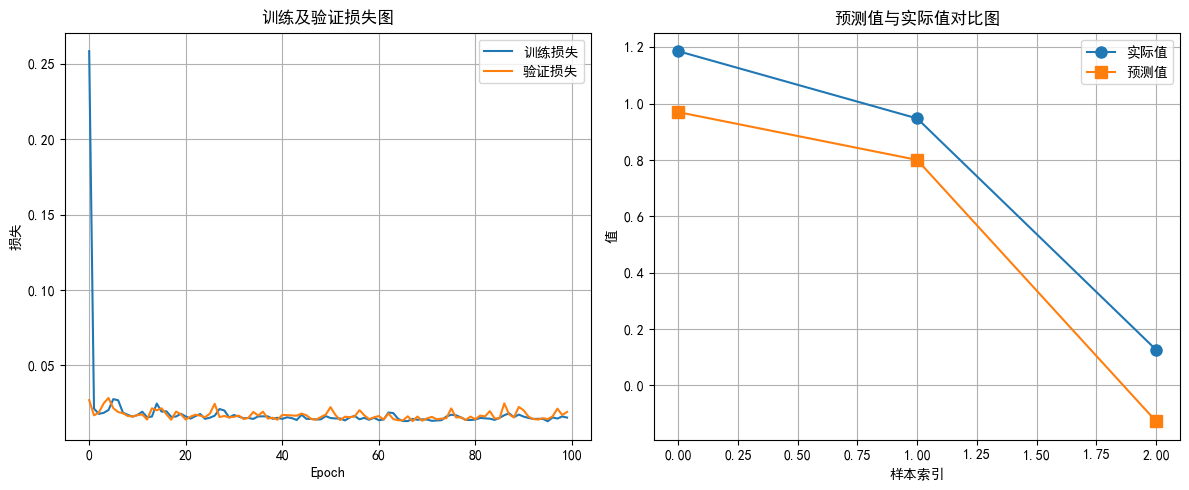

In [28]:
"""GRU实现"""

torch.manual_seed(88)
np.random.seed(66)

class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
        """初始化权重"""
        self.init_weight()
        
    def init_weight(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
                
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        """初始化隐状态"""
        if hidden is None:
            hidden = self.init_hidden(batch_size, x.device)
            
        gru_out, hidden = self.gru(x, hidden)
        
        """读取最后一个时间步的输出"""
        last_output = gru_out[:, -1, :]
        
        output = self.fc(last_output)
        
        return  output, hidden
    
    def init_hidden(self, batch_size, device):
        """初始化隐藏状态"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
            
def generate_time_series_data(seq_length=20, num_sample=1000, input_size=1):
    """生成时间序列数据"""
    data = []
    labels = []
        
    for _ in range(num_sample):
        base = np.random.normal(0, 1)
        trend = np.linspace(0, np.random.normal(0, 0.5), seq_length)
        noise = np.random.normal(0, 0.1, seq_length)
        
        series = base + trend + noise
        series = series.reshape(seq_length, input_size)
        
        data.append(series[:-1])
        labels.append(series[-1])
    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        """训练阶段"""
        model.train()
        train_loss = 0.0
        
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            
            """梯度裁剪，防止梯度爆炸"""
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * batch_data.size(0)
            
        """验证阶段"""
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for batch_data, batch_labels in test_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs, _ = model(batch_data)
                loss = criterion(outputs, batch_labels)
                test_loss += loss.item() * batch_data.size(0)
                
        """平均损失"""
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_test_loss = test_loss / len(test_loader.dataset)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

def main():
    seq_length = 20
    input_size = 1
    hidden_size = 64
    output_size = 1
    num_layers = 2
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.01
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'当前设备：{device}')
    
    """生成数据"""
    train_data, train_labels = generate_time_series_data(seq_length, 800, input_size)
    test_data, test_labels = generate_time_series_data(seq_length, 200, input_size)
    
    """数据类型转化"""
    train_data = torch.from_numpy(train_data)
    train_labels = torch.from_numpy(train_labels)
    test_data = torch.from_numpy(test_data)
    test_labels = torch.from_numpy(test_labels)
    
    """数据加载器"""
    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = SimpleGRU(input_size, hidden_size, output_size, num_layers).to(device)
    print(f"模型参数量：{sum(p.numel() for p in model.parameters()):,}")
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print("训练开始...")
    train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
    
    """损失曲线"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='训练损失')
    plt.plot(test_losses, label="验证损失")
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练及验证损失图')
    plt.legend()
    plt.grid(True)
    
    """预测测试"""
    model.eval()
    with torch.no_grad():
        sample_indices = [0, 5, 10]
        predictions = []
        actuals = []
        
        for idx in sample_indices:
            sample_data = test_data[idx:idx+1].to(device)
            sample_label = test_labels[idx:idx+1].to(device)
            
            prediction, _ = model(sample_data)
            
            predictions.append(prediction.cpu().numpy().item())
            actuals.append(sample_label.cpu().numpy().item())
            
        plt.subplot(1, 2, 2)
        plt.plot(actuals, 'o-', label='实际值', markersize=8)
        plt.plot(predictions, 's-', label='预测值', markersize=8)
        plt.xlabel('样本索引')
        plt.ylabel('值')
        plt.title('预测值与实际值对比图')
        plt.legend()
        plt.grid(True)
        
    
    print("\n预测结果:")
    for i, (actual, pred) in enumerate(zip(actuals, predictions)):
        print(f"样本 {i}: 真实值 = {actual:.4f}, 预测值 = {pred:.4f}, 误差 = {abs(actual - pred):.4f}")
        
    """模型保存"""
    torch.save(model.state_dict(), './GRU_model/gru_model.pth')
    print("模型已保存!")
    
    plt.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    main()

## 长短期记忆网络
### 门控记忆元
- **输入门**：决定要往记忆元里写入多少新信息。
- **遗忘门**：决定要“丢弃”多少旧信息。
- **输出门**：决定当前时刻要“输出”多少信息给隐藏状态$h_t$。

![门控记忆元](../image/门控记忆元.jpg)
$$
\begin{align}
I_t &= \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i), \\
F_t &= \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f), \\
O_t &= \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o),
\end{align}
$$
- **候选记忆元**
$$\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c),$$

![候选记忆元](../image/候选记忆元.jpg)

- **记忆元**
$$C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t,$$
工作流程：输入门$I_t$控制采用多少来自$\tilde{C}_t$的新数据，而遗忘门$F_t$控制保留多少过去的记忆元$C_{t-1}\in \mathbb{R}^{n\times h}$的内容.
如果遗忘门始终为1且输入门始终为0，则过去的记忆元$C_{t-1}$ 将随时间被保存并传递到当前时间步；引入这种设计是为了缓解梯度消失问题，并更好地捕获序列中的长距离依赖关系。

![记忆元计算](../image/记忆元计算.jpg)

当前设备cuda
数据形状: X=(5000, 20, 1), y=(5000, 1)
训练集: torch.Size([4000, 20, 1]), 测试集: torch.Size([1000, 20, 1])
总参数量：8.47426986694336
Epoch [10/100], Train Loss: 0.365533, Test Loss: 0.379150
Epoch [20/100], Train Loss: 0.201546, Test Loss: 0.190223
Epoch [30/100], Train Loss: 0.110341, Test Loss: 0.106525
Epoch [40/100], Train Loss: 0.031776, Test Loss: 0.030092
Epoch [50/100], Train Loss: 0.010435, Test Loss: 0.008330
Epoch [60/100], Train Loss: 0.002303, Test Loss: 0.002323
Epoch [70/100], Train Loss: 0.001826, Test Loss: 0.001750
Epoch [80/100], Train Loss: 0.000871, Test Loss: 0.000712
Epoch [90/100], Train Loss: 0.000599, Test Loss: 0.000503
Epoch [100/100], Train Loss: 0.000513, Test Loss: 0.000460

模型评估:
均方误差 (MSE): 0.000553
R² 分数: 0.998928

多步预测示例:
初始序列: [ 0.23563549  0.13743603  0.03786337 -0.06208762 -0.16141824]
预测的下一个值: -0.2702
实际的下一个值: -0.2591
预测的未来5个值: [-0.2702 -0.3698 -0.4641 -0.5526 -0.6342]
模型已保存为 'basic_lstm_model.pth'


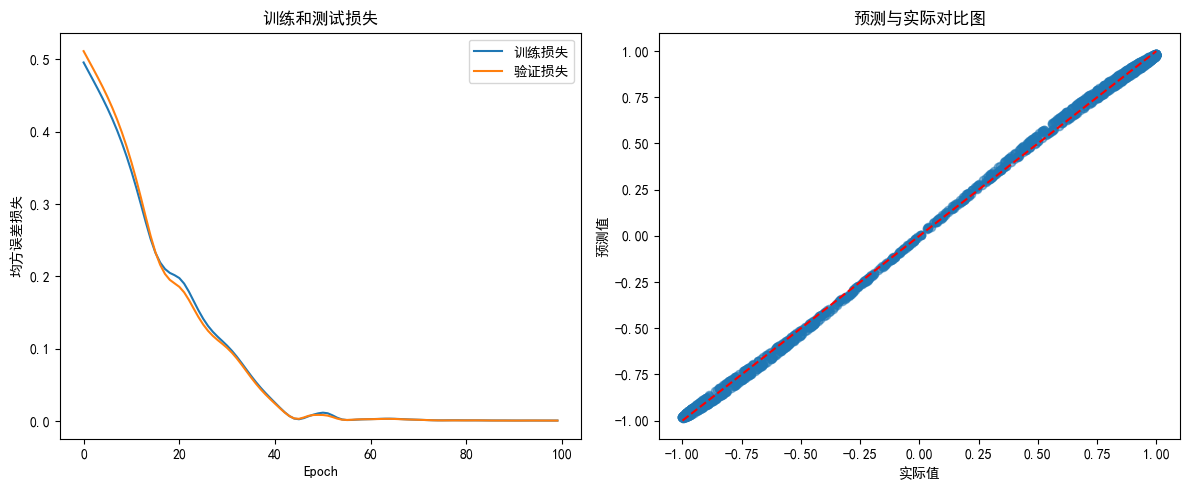

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

"""经典长短期记忆网络"""
from sklearn.model_selection import train_test_split

torch.manual_seed(66)
np.random.seed(88)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'当前设备{device}')

"""正弦数据生成"""
def generate_sin_data(seq_length=50, num_samples=1000):
    X = []
    y = []
    
    for i in range(num_samples):
        start = np.random.uniform(0, 2 * np.pi)
        
        sequence = []
        for j in range(seq_length + 1):
            value = np.sin(start + j * 0.1)
            sequence.append(value)
            
        X.append(sequence[:-1])
        y.append(sequence[-1])
        
    return np.array(X), np.array(y)

seq_length = 20
X, y = generate_sin_data(seq_length=seq_length, num_samples=5000)

X = X.reshape(-1, seq_length, 1)
y = y.reshape(-1, 1)

print(f"数据形状: X={X.shape}, y={y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")

class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasicLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        """初始化隐藏状态"""
        self.hidden = None
        
    def forward(self, x):
        batch_size = x.size(0)
        """如果出现不同批次的数据，那么就需要调整隐藏状态的维度所以需要检查这个当前的输入维度和隐藏状态维度是否一致"""
        if self.hidden is None or self.hidden[0].size(1) != batch_size:
            self.init_hidden(batch_size)
            
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        """初始化隐藏状态"""
        weight = next(self.parameters()).data
        self.hidden = (
            weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
            weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        )
        
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

model = BasicLSTM(input_size, hidden_size, num_layers, output_size).to(device)

total_params = sum(p.sum() for p in model.parameters())
print(f"总参数量：{total_params}")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        """训练阶段"""
        model.train()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        
        """梯度裁剪"""
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        """验证阶段"""
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            train_loss = criterion(train_outputs, y_train)
            
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss.item():.6f}, '
                  f'Test Loss: {test_loss.item():.6f}')
            
    return train_losses, test_losses

train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, num_epochs=100)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(test_losses, label='验证损失')
plt.xlabel('Epoch')
plt.ylabel('均方误差损失')
plt.title('训练和测试损失')
plt.legend()

model.eval()
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()
    actual = y_test.cpu().numpy()
    
plt.subplot(1, 2, 2)
plt.scatter(actual, predictions, alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('预测与实际对比图')
plt.tight_layout()

mse = mean_squared_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"\n模型评估:")
print(f"均方误差 (MSE): {mse:.6f}")
print(f"R² 分数: {r2:.6f}")

def predict_sequence(model, initial_sequence, steps=10):
    """预测未来多个时间步"""
    model.eval()
    predictions = []
    current_sequence = initial_sequence.clone()
    
    with torch.no_grad():
        for _ in range(steps):
            next_value = model(current_sequence.unsqueeze(0))
            predictions.append(next_value.item())
            
            current_sequence = torch.cat([current_sequence[1:], next_value])
            
    return  predictions

sample_idx = 0
initial_sequence = X_test[sample_idx]
true_future = [y_test[sample_idx].item()]

predicted_future = predict_sequence(model, initial_sequence, steps=5)

print(f"\n多步预测示例:")
print(f"初始序列: {initial_sequence[-5:].flatten().cpu().numpy()}")  # 显示最后5个点
print(f"预测的下一个值: {predicted_future[0]:.4f}")
print(f"实际的下一个值: {true_future[0]:.4f}")
print(f"预测的未来5个值: {np.array(predicted_future).round(4)}")

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size
    }
}, 'SimpleLSTM/basic_lstm_model.pth')

print("模型已保存为 'basic_lstm_model.pth'")

plt.show()

## 深度循环神经网络


In [30]:
"""双向长短期记忆（LSTM）循环神经网络"""
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from torch.utils.data import Dataset

torch.manual_seed(66)
np.random.seed(99)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"当前使用的设备是：{device}")

class THUCNewsDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_length=200):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        """文本转换为索引序列"""
        indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in text]
        
        """填充（或者截断）"""
        if len(indices) < self.max_length:
            indices = indices + [self.word2idx['<PAD>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
            
        return torch.LongTensor(indices), torch.LongTensor([label])
    
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
            
        hidden = self.dropout(hidden)
        return self.fc(hidden)
        
def load_thucnews_from_local(data_dir, stopwords):
    """加载新闻数据集"""
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
    texts = []
    labels = []
        
    print("正在加载数据集...")
        
    for label_idx, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        
        if not os.path.exists(category_dir):
            print(f"警告：目录 {category_dir} 不存在，跳过")
            continue
            
        files = os.listdir(category_dir)
        print(f"类别 '{category}' 中找到 {len(files)} 个文件")
        
        for i, filename in enumerate(files):
            if i == 0:
                print(f"开始处理类别 '{category}'")
                
            if i == len(files) - 1:
                print(f"类别 '{category}' 处理完毕")
                
            file_path = os.path.join(category_dir, filename)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read().strip()
                    processed_text = preprocess_text(content, stopwords)
                    if content:
                        texts.append(processed_text)
                        labels.append(label_idx)
            except Exception as e:
                print(f"读取文件 {file_path} 时出错: {e}")
                
    print(f"总共加载 {len(texts)} 个样本")
    return texts, labels, categories

def load_hit_stopwords(stopwords_path):
    """加载停用词表"""
    stopwords = set()
    try:
        with open(stopwords_path, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if word:
                    stopwords.add(word)
        print(print(f"成功加载 {len(stopwords)} 个停用词"))
        return stopwords
    except FileNotFoundError:
        print(f"警告: 停用词文件 {stopwords_path} 未找到，将不使用停用词过滤")
        return set()
    except Exception as e:
        print(f"加载停用词表时出错: {e}")
        return set()

def preprocess_text(text, stopwords):
    """文本预处理"""
    text = re.sub(r'[^\u4e00-\u9fa5\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    words = jieba.lcut(text)
    
    filtered_words = []
    for word in words:
        word = word.strip()
        if word and len(word) > 1 and word not in stopwords and not word.isspace():
            filtered_words.append(word)
    
    return filtered_words

def build_vocab(texts, max_vocab_size=10000):
    """构建词汇表（词袋）"""
    word_counter = Counter()
    
    print("正在构建词汇表...")
    for i, words in enumerate(texts):
        if i % 100000 == 0 and i > 0:
            print(f"处理文本 {i}/{len(texts)}")
        word_counter.update(words)
        
    most_common = word_counter.most_common(max_vocab_size - 2)
    
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    idx2word = {0: '<PAD>', 1: '<UNK>'}
    
    for idx, (word, count) in enumerate(most_common, start=2):
        word2idx[word] = idx
        idx2word[idx] = word
        
    return word2idx, idx2word

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    """模型训练"""
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        """训练阶段"""
        model.train()
        total_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.squeeze().to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            """梯度裁剪：连续时间步的反向传播带来的矩阵乘法链可能会导致梯度爆炸或者消失，梯度裁剪就是来解决这个的（梯度爆炸，不解决梯度消失），加入学习率是α，那么是将x更新为x-αg，g是负梯度方向"""
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 1000 == 0 and batch_idx > 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        """验证阶段"""
        model.eval()
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.squeeze().to(device)
                output = model(data)
                preds = output.argmax(dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                
        accuracy = accuracy_score(all_targets, all_preds)
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.4f}')
    
    return train_losses, val_accuracies

def main():
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 128
    OUTPUT_DIM = 10
    N_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.5
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    MAX_VOCAB_SIZE = 10000
    MAX_LENGTH = 200
    
    DATA_DIR = r'E:\THUCNews'
    STOPWORDS_PATH = r'E:\Python\DLL\data\hit_stopwords.txt'
    
    """加载停用词表"""
    print("停用词表加载...")
    stopwords = load_hit_stopwords(STOPWORDS_PATH)
    
    """数据加载"""
    print("加载清华新闻数据集...")
    texts, labels, categories = load_thucnews_from_local(DATA_DIR, stopwords)
    
    if len(texts) == 0:
        print("错误: 没有加载到任何数据，请检查数据集路径")
        return
    
    """构建词汇表（词袋）"""
    word2idx, idx2word = build_vocab(texts, MAX_VOCAB_SIZE)
    vocab_size = len(word2idx)
    
    processed_texts = texts
    
    """数据集划分"""
    train_texts, test_texts, train_labels, test_labels = train_test_split(processed_texts, labels, test_size=0.2, random_state=88, stratify=labels)
    
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=88, stratify=train_labels)
    
    print(f"训练集: {len(train_texts)}, 验证集: {len(val_texts)}, 测试集: {len(test_texts)}")
    
    """数据集创建以及数据加载器的创建"""
    train_dataset = THUCNewsDataset(train_texts, train_labels, word2idx, MAX_LENGTH)
    val_dataset = THUCNewsDataset(val_texts, val_labels, word2idx, MAX_LENGTH)
    texts_dataset = THUCNewsDataset(test_texts, test_labels, word2idx, MAX_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(texts_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    """模型创建"""
    model = TextRNN(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, word2idx['<PAD>'])
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型总参数: {total_params:,}")
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    """开始训练"""
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS)
    
    """训练曲线图"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='训练损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='验证准确率', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    """测试集评估"""
    print("在测试集上评估...")
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.squeeze().to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_accuracy = accuracy_score(all_targets, all_preds)
    print(f'测试集准确率: {test_accuracy:.4f}')
    print('\n分类报告:')
    print(classification_report(all_targets, all_preds, target_names=categories))
    
    # 保存模型和词汇表
    torch.save({
        'model_state_dict': model.state_dict(),
        'word2idx': word2idx,
        'idx2word': idx2word,
        'categories': categories,
        'max_length': MAX_LENGTH,
        'model_config': {
            'vocab_size': vocab_size,
            'embed_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'output_dim': OUTPUT_DIM,
            'n_layers': N_LAYERS,
            'bidirectional': BIDIRECTIONAL,
            'dropout': DROPOUT
        }
    }, 'RNN_model/thucnews_rnn_model.pth')
    
    """保存词汇表到文本文件，便于查看"""
    with open('RNN_model/vocabulary.txt', 'w', encoding='utf-8') as f:
        for word, idx in sorted(word2idx.items(), key=lambda x: x[1]):
            f.write(f"{idx}\t{word}\n")
    
    print("模型已保存为 'RNN_model/thucnews_rnn_model.pth'")
    print("词汇表已保存为 'RNN_model/vocabulary.txt'")
    
def predict_text(text, model_path='RNN_model/thucnews_rnn_model.pth', stopwords_path=None):
    """测试一下加载模型参数来预测"""
    if stopwords_path:
        stopwords = load_hit_stopwords(stopwords_path)
    else:
        stopwords = set()
        
    """模型加载"""
    checkpoint = torch.load(model_path, map_location=device)
    
    model = TextRNN(
        vocab_size=checkpoint['model_config']['vocab_size'],
        embed_dim=checkpoint['model_config']['embed_dim'],
        hidden_dim=checkpoint['model_config']['hidden_dim'],
        output_dim=checkpoint['model_config']['output_dim'],
        n_layers=checkpoint['model_config']['n_layers'],
        bidirectional=checkpoint['model_config']['bidirectional'],
        dropout=checkpoint['model_config']['dropout'],
        pad_idx=checkpoint['word2idx']['<PAD>']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    words = preprocess_text(text, stopwords)
    print(f"预处理后的词: {words[:20]}...")  # top20
    
    """索引转换"""
    indices = [checkpoint['word2idx'].get(word, checkpoint['word2idx']['<UNK>']) for word in words]
    
    max_length = checkpoint['max_length']
    if len(indices) < max_length:
        indices = indices + [checkpoint['word2idx']['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
        
    tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(tensor)
        prediction = output.argmax(dim=1).item()
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()
    
    return checkpoint['categories'][prediction], probabilities, words

当前使用的设备是：cuda


停用词表加载...
成功加载 749 个停用词
None
加载清华新闻数据集...
正在加载数据集...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DaiYongle\AppData\Local\Temp\jieba.cache


类别 '体育' 中找到 131604 个文件
开始处理类别 '体育'


Loading model cost 1.080 seconds.
Prefix dict has been built successfully.


类别 '体育' 处理完毕
类别 '财经' 中找到 37098 个文件
开始处理类别 '财经'
类别 '财经' 处理完毕
类别 '房产' 中找到 20050 个文件
开始处理类别 '房产'
类别 '房产' 处理完毕
类别 '家居' 中找到 32586 个文件
开始处理类别 '家居'
类别 '家居' 处理完毕
类别 '教育' 中找到 41936 个文件
开始处理类别 '教育'
类别 '教育' 处理完毕
类别 '科技' 中找到 162929 个文件
开始处理类别 '科技'
类别 '科技' 处理完毕
类别 '时尚' 中找到 13368 个文件
开始处理类别 '时尚'
类别 '时尚' 处理完毕
类别 '时政' 中找到 63086 个文件
开始处理类别 '时政'
类别 '时政' 处理完毕
类别 '游戏' 中找到 24373 个文件
开始处理类别 '游戏'
类别 '游戏' 处理完毕
类别 '娱乐' 中找到 92632 个文件
开始处理类别 '娱乐'
类别 '娱乐' 处理完毕
总共加载 619661 个样本
正在构建词汇表...
处理文本 100000/619661
处理文本 200000/619661
处理文本 300000/619661
处理文本 400000/619661
处理文本 500000/619661
处理文本 600000/619661
训练集: 446155, 验证集: 49573, 测试集: 123933
模型总参数: 1,633,354
Epoch 1, Batch 1000, Loss: 0.4855
Epoch 1, Batch 2000, Loss: 0.2297
Epoch 1, Batch 3000, Loss: 0.1160
Epoch 1, Batch 4000, Loss: 0.0431
Epoch 1, Batch 5000, Loss: 0.1842
Epoch 1, Batch 6000, Loss: 0.2534
Epoch 1/10, Loss: 0.3861, Val Accuracy: 0.9570
Epoch 2, Batch 1000, Loss: 0.0683
Epoch 2, Batch 2000, Loss: 0.0620
Epoch 2, Batch 3000, Loss: 0.2177
Epoch 2, Batch 

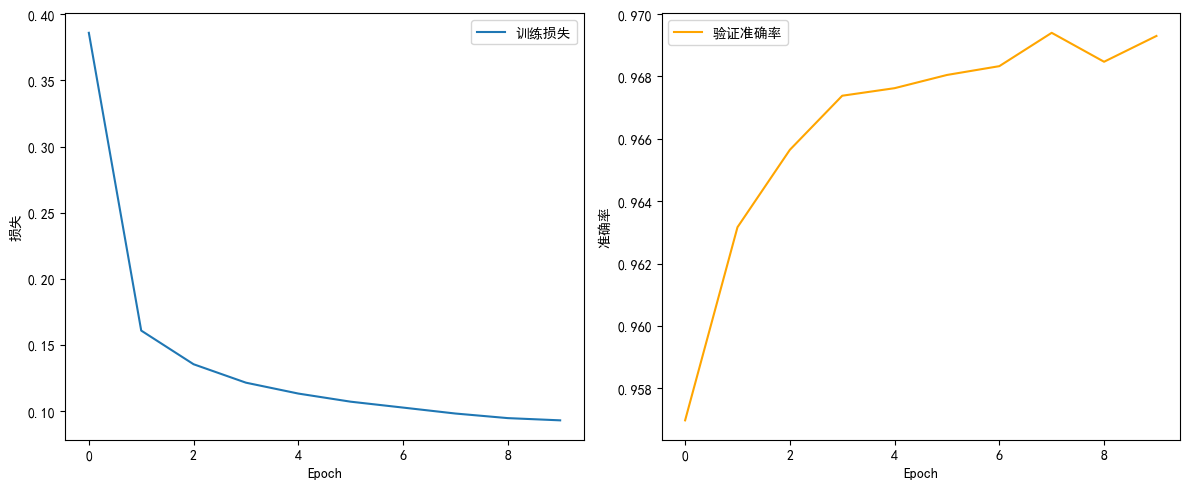

在测试集上评估...
测试集准确率: 0.9702

分类报告:
              precision    recall  f1-score   support

          体育       0.99      0.99      0.99     26321
          财经       0.97      0.96      0.97      7420
          房产       0.97      0.95      0.96      4010
          家居       0.95      0.94      0.95      6517
          教育       0.97      0.97      0.97      8387
          科技       0.97      0.97      0.97     32586
          时尚       0.93      0.96      0.94      2674
          时政       0.94      0.97      0.95     12617
          游戏       0.95      0.92      0.94      4875
          娱乐       0.98      0.97      0.98     18526

    accuracy                           0.97    123933
   macro avg       0.96      0.96      0.96    123933
weighted avg       0.97      0.97      0.97    123933

模型已保存为 'RNN_model/thucnews_rnn_model.pth'
词汇表已保存为 'RNN_model/vocabulary.txt'

进行预测测试...
成功加载 749 个停用词
None


FileNotFoundError: [Errno 2] No such file or directory: 'thucnews_rnn_model.pth'

In [31]:
"""循环神经网络调用训练及预测"""

DATA_DIR = r"E:\THUCNews"
STOPWORDS_PATH = r"E:\Python\DLL\data\hit_stopwords.txt"

main()

print("\n进行预测测试...")
test_texts = [
    "股市今日大涨，上证指数突破3000点，投资者信心增强",
    "中国男篮在国际篮球比赛中获得冠军，队员表现出色",
    "新款智能手机发布，搭载最新处理器和人工智能芯片",
    "房地产市场调控政策出台，房价趋于稳定",
    "教育部发布新政策，推进教育信息化发展"
]

for text in test_texts:
    prediction, probs, processed_words = predict_text(text, 'thucnews_rnn_model.pth', STOPWORDS_PATH)
    print(f"文本: {text}")
    print(f"预处理后的词: {processed_words[:10]}...")  # 显示前10个处理后的词
    print(f"预测类别: {prediction}")
    print("-" * 50)

## 双向循环神经网络
### 隐马尔可夫模型中的动态规划
#### 前向算法
- 目的就是在一个序列中计算当前位置的观测状态的概率，会考虑到当前状态前后若干个位置的观测和隐状态，由于当前计算的这个状态概率没有隐变量，所以考虑使用前后若干个隐变量的所有可能求和：
$$\pi_{t+1}(h_{t+1})=\sum_{h_t}\pi_t(h_t)P(x_t|h_t)P(h_{t+1}|h_t).$$
- $t$从零开始，也可以简化成$\pi_{t+1}=f(\pi_t,x_t)$，其中$f$是一些可学习的函数，就像参数更新方程。
#### 后向算法
- 和前向算法是一样的求和方式：
$$\rho_{t-1}(h_{t-1})=\sum_{h_t}P(h_t|h_{t-1})P(x_t|h_t)\rho_t(h_t),$$
- 初始化$\rho_T(h_T)=1$

- 结合上述前向后后向算法得到：
$$P(x_j|x_{-j})\varpropto\sum_{h_j}\pi_j(h_j)\rho_j(h_j)P(x_j|h_j).$$
- 后向算法部分也可以写为 $\rho_{t-1}=g(\rho_t,x_t)$，其中$g$也是一个可恶意学习的函数（参数更新方程）
### 双向模型
- 和隐马尔可夫模型的动态和规划的前后向递归算法没有太大区别
- 对于任意时间步$t$，给定一个小批量的输入数据 $\mathrm{X}_t\in \mathbb{R}^{n\times d}$（样本数$n$，每个示例中的输入数$d$），并且令隐藏层激活函数为$\phi$。在双向架构中，我们设该时间步的前向和反向隐状态分别为$\overrightarrow{H}_t\in\mathbb{R}^{n\times h}$和$\overleftarrow{H}_t\in\mathbb{R}^{n\times h}$，其中$h$是隐藏单元的数目。前向、后向隐状态的更新方法：
$$\overrightarrow{H}_t=\phi(\mathrm{X}_t\mathrm{W}_{xh}^{(f)}+\overrightarrow{H}_{t-1}\mathrm{W}_{hh}^{(f)}+\mathrm{b}_h^{(f)}),\\\overleftarrow{H}_t=\phi(\mathrm{X}_t\mathrm{W}_{xh}^{(b)}+\overrightarrow{H}_{t-1}\mathrm{W}_{hh}^{(b)}+\mathrm{b}_h^{(b)}),$$
- 其中，权重$\mathrm{W}_{xh}^{(f)}\in\mathbb{R}^{d\times h},\mathrm{W}_{hh}^{(f)}\in\mathbb{R}^{h\times h},\mathrm{W}_{xh}^{(b)}\in\mathbb{R}^{d\times h},\mathrm{W}_{hh}^{(b)}\in\mathbb{R}^{h\times h}$ 和 $\mathrm{b}_h^{(f)}\in\mathbb{R}^{1\times h},\mathrm{b}_h^{(b)}\in\mathbb{R}^{1\times h}$ 都是模型参数。
- 接下来，将前向隐状态$\overrightarrow{H}_t$和反向隐状态$\overleftarrow{H}_t$连接起来，获得需要送入输出层的隐状态$\mathrm{H}_t\in\mathbb{R}^{n\times 2h}$。在具有多个隐藏层的深度双向循环神经网络中，该信息作为输入传递到下一个双向层。最后，输出层计算得到的输出为$\mathrm{O}_t\in\mathbb{R}^{n\times q}$（$q$是输出单元的数目）：
$$\mathrm{O}_t=\mathrm{H}_t\mathrm{W}_{hq}+\mathrm{b}_q.$$
- 这里，权重矩阵$\mathrm{W}_{hq}\in\mathbb{R}^{2h\times q}$和偏置$\mathrm{b}_q\in\mathbb{R}^{1\times q}$是输出层的模型参数。事实上，这两个方向可以拥有不同数量的隐藏单元。
## 机器翻译与数据集

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DaiYongle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DaiYongle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


加载 20000 条句对。
示例分词结果：
EN: sorry about that , mr ....
ZH: 抱歉   怎么 称呼
词表：SRC=4256, TGT=5911
Epoch 1/10 - Loss: 5.5962 - Acc: 19.16%
Epoch 2/10 - Loss: 5.1371 - Acc: 23.05%
Epoch 3/10 - Loss: 4.8351 - Acc: 25.70%
Epoch 4/10 - Loss: 4.5488 - Acc: 27.72%
Epoch 5/10 - Loss: 4.2655 - Acc: 29.60%
Epoch 6/10 - Loss: 3.9977 - Acc: 31.34%
Epoch 7/10 - Loss: 3.7358 - Acc: 33.30%
Epoch 8/10 - Loss: 3.4540 - Acc: 35.85%
Epoch 9/10 - Loss: 3.1688 - Acc: 38.86%
Epoch 10/10 - Loss: 2.8845 - Acc: 42.36%
Input: I love you
Translation: 我爱你


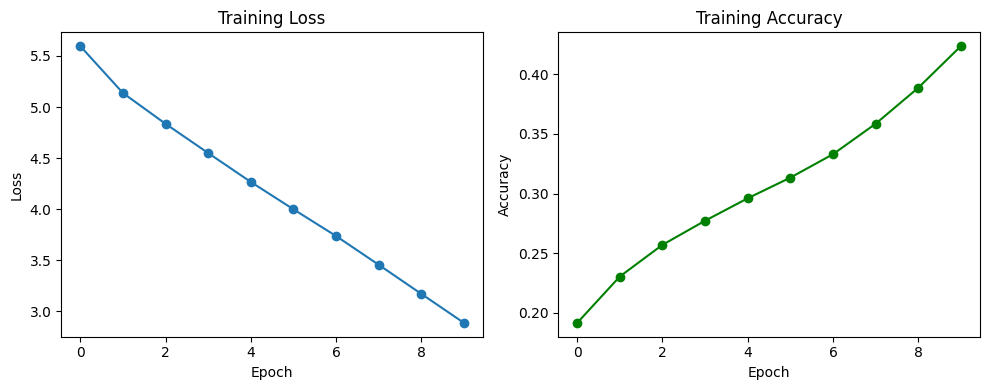

In [2]:
# ==============================================
# 双向 LSTM Seq2Seq 中文↔英文翻译模型（自动分词 + 训练可视化）
# ==============================================

import os
import random
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import jieba
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')

# --------------------------
# 参数配置
# --------------------------
EMB_SIZE = 256
HID_SIZE = 512
NUM_LAYERS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10
TEACHER_FORCING_RATIO = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 40

# --------------------------
# 数据读取 & 预处理
# --------------------------
def clean_text(text):
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

def load_parallel_data(path_en, path_zh, max_lines=None):
    en_sents, zh_sents = [], []
    with open(path_en, encoding='utf-8') as fe, open(path_zh, encoding='utf-8') as fz:
        for i, (le, lz) in enumerate(zip(fe, fz)):
            le = clean_text(le)
            lz = clean_text(lz)
            if not le or not lz:
                continue
            en_sents.append(le)
            zh_sents.append(lz)
            if max_lines and len(en_sents) >= max_lines:
                break
    print(f"加载 {len(en_sents)} 条句对。")
    return en_sents, zh_sents

# ====== 这里改成你的实际路径 ======
en_file = "../data/train.en"
zh_file = "../data/train.zh"

en_raw, zh_raw = load_parallel_data(en_file, zh_file, max_lines=20000)

# --------------------------
# 分词
# --------------------------
def tokenize_en(sent):
    return nltk.word_tokenize(sent.lower())

def tokenize_zh(sent):
    return list(jieba.cut(sent))

en_sents = [" ".join(tokenize_en(s)) for s in en_raw]
zh_sents = [" ".join(tokenize_zh(s)) for s in zh_raw]

print("示例分词结果：")
print("EN:", en_sents[0])
print("ZH:", zh_sents[0])

# --------------------------
# 构建词表
# --------------------------
def build_vocab(sentences, min_freq=2):
    freq = {}
    for sent in sentences:
        for w in sent.split():
            freq[w] = freq.get(w, 0) + 1
    token2idx = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}
    for w, c in freq.items():
        if c >= min_freq:
            token2idx[w] = len(token2idx)
    idx2token = {i:w for w, i in token2idx.items()}
    return token2idx, idx2token

src2idx, idx2src = build_vocab(en_sents)
tgt2idx, idx2tgt = build_vocab(zh_sents)
SRC_VOCAB, TGT_VOCAB = len(src2idx), len(tgt2idx)
print(f"词表：SRC={SRC_VOCAB}, TGT={TGT_VOCAB}")

# --------------------------
# Dataset
# --------------------------
class TranslationDataset(Dataset):
    def __init__(self, src_sents, tgt_sents, src2idx, tgt2idx):
        self.src_sents = src_sents
        self.tgt_sents = tgt_sents
        self.src2idx = src2idx
        self.tgt2idx = tgt2idx

    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, idx):
        src_tokens = self.src_sents[idx].split()
        tgt_tokens = self.tgt_sents[idx].split()

        src_ids = [self.src2idx.get(w, self.src2idx["<unk>"]) for w in src_tokens]
        tgt_ids = [self.tgt2idx.get(w, self.tgt2idx["<unk>"]) for w in tgt_tokens]

        src_ids = [self.src2idx["<sos>"]] + src_ids + [self.src2idx["<eos>"]]
        tgt_ids = [self.tgt2idx["<sos>"]] + tgt_ids + [self.tgt2idx["<eos>"]]

        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lens = [len(x) for x in src_batch]
    tgt_lens = [len(x) for x in tgt_batch]
    max_src, max_tgt = max(src_lens), max(tgt_lens)
    pad = 0
    src_pad = [torch.cat([x, torch.full((max_src - len(x),), pad)]) for x in src_batch]
    tgt_pad = [torch.cat([x, torch.full((max_tgt - len(x),), pad)]) for x in tgt_batch]
    src_tensor = torch.stack(src_pad, dim=1)
    tgt_tensor = torch.stack(tgt_pad, dim=1)
    return src_tensor.long(), tgt_tensor.long(), src_lens, tgt_lens

dataset = TranslationDataset(en_sents, zh_sents, src2idx, tgt2idx)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# --------------------------
# 模型定义
# --------------------------
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hid_size, bidirectional=True)
        self.fc_h = nn.Linear(hid_size * 2, hid_size)
        self.fc_c = nn.Linear(hid_size * 2, hid_size)

    def forward(self, src, src_lens):
        embedded = self.embedding(src)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        h_cat = torch.cat((h[0], h[1]), dim=1)
        c_cat = torch.cat((c[0], c[1]), dim=1)
        h0 = torch.tanh(self.fc_h(h_cat)).unsqueeze(0)
        c0 = torch.tanh(self.fc_c(c_cat)).unsqueeze(0)
        return h0, c0

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hid_size)
        self.fc_out = nn.Linear(hid_size, vocab_size)

    def forward(self, input_tok, hidden, cell):
        input_tok = input_tok.unsqueeze(0)
        embedded = self.embedding(input_tok)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        pred = self.fc_out(output.squeeze(0))
        return pred, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lens, teacher_forcing_ratio=0.5):
        batch_size = tgt.shape[1]
        tgt_len = tgt.shape[0]
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(tgt_len, batch_size, vocab_size).to(self.device)
        hidden, cell = self.encoder(src, src_lens)
        input_tok = tgt[0, :]
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_tok, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_tok = tgt[t] if teacher_force else top1
        return outputs

# --------------------------
# 训练 & 可视化
# --------------------------
model = Seq2Seq(Encoder(SRC_VOCAB, EMB_SIZE, HID_SIZE),
                Decoder(TGT_VOCAB, EMB_SIZE, HID_SIZE),
                DEVICE).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_losses, train_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss, total_acc, total_tokens = 0, 0, 0

    for src, tgt, src_lens, tgt_lens in dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(src, tgt, src_lens, TEACHER_FORCING_RATIO)
        output_dim = outputs.shape[-1]
        loss = criterion(outputs[1:].reshape(-1, output_dim), tgt[1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        # ===== 准确率（忽略PAD） =====
        preds = outputs[1:].argmax(-1)
        mask = (tgt[1:] != 0)
        correct = (preds == tgt[1:]) & mask
        total_acc += correct.sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / total_tokens
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {avg_loss:.4f} - Acc: {avg_acc*100:.2f}%")

# --------------------------
# 翻译函数
# --------------------------
def translate(model, sentence, src2idx, idx2tgt):
    model.eval()
    src_tokens = tokenize_en(sentence)
    src_ids = [src2idx.get(w, src2idx["<unk>"]) for w in src_tokens]
    src_ids = [src2idx["<sos>"]] + src_ids + [src2idx["<eos>"]]
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(DEVICE)
    src_len = [len(src_ids)]
    hidden, cell = model.encoder(src_tensor, src_len)
    input_tok = torch.tensor([tgt2idx["<sos>"]], dtype=torch.long).to(DEVICE)
    outputs = []
    for _ in range(MAX_LEN):
        pred, hidden, cell = model.decoder(input_tok, hidden, cell)
        top1 = pred.argmax(1).item()
        if top1 == tgt2idx["<eos>"]:
            break
        outputs.append(top1)
        input_tok = torch.tensor([top1], dtype=torch.long).to(DEVICE)
    return "".join([idx2tgt[i] for i in outputs])

# --------------------------
# 测试翻译
# --------------------------
test_sentence = "I love you"
print("Input:", test_sentence)
print("Translation:", translate(model, test_sentence, src2idx, idx2tgt))

# ===== 绘图 =====
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

## 编码器-解码器架构
- 编码器：接受一个长度可变的序列作为输入->固定形状的编码状态。
- 解码器：固定编码状态->长度可变的序列。

![编码解码架构](../image/编码解码架构.jpg)

### 编码器

In [1]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器的基本编码器接口"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError

### 解码器

In [2]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

### 合并编码器和解码器

In [9]:


class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 序列到序列学习
- 架构上还是编码器-解码器架构
- <eos> 表示一个序列词元的结束，<bos> 表示序列词元的开始
### 编码器
- tensor.permute()：重新排列张量的维度，比如一个原来是(a,b,c)排列的张量经过permute(1, 0, 2)转换之后变成(b, a, c)。


In [2]:
import collections
import torch
from torch import nn

class Encoder(nn.Module):
    """编码器基类"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
    
    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps, batch_size, num_hiddens)
        # state的形状:(num_layers, batch_size, num_hiddens)
        return output, state

# 测试代码
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print(f"Output shape: {output.shape}")
print(f"State shape: {state.shape}")

Output shape: torch.Size([7, 4, 16])
State shape: torch.Size([2, 4, 16])


### 解码器
- 解码器利用编码器生成的上下文向量和自身已生成的输出序列，通过循环神经网络在每个时间步整合上下文信息、上一时刻输出和隐状态，计算当前时刻所有可能输出词元的概率分布，从而以自回归的方式逐个生成目标序列的词元，直到产生序列结束标记为止。
- 整个流程：

![编码-解码（序列模型）](../image/编码器-解码器（序列模型）.jpg)

In [3]:
import torch
from torch import nn

class Decoder(nn.Module):
    """解码器基类"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, *args):
        # enc_outputs[1] 是编码器的最终隐状态
        return enc_outputs[1]
    
    def forward(self, X, state):
        # 输出'X'的形状：(batch_size, num_steps, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        # state[-1] 取最后一层的隐状态，然后重复以匹配时间步数
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 将输入嵌入和上下文向量在特征维度上拼接
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size, num_steps, vocab_size)
        # state的形状:(num_layers, batch_size, num_hiddens)
        return output, state

# 测试代码
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)
enc_output = encoder(X)
state = decoder.init_state(enc_output)
output, state = decoder(X, state)

print(f"Output shape: {output.shape}")
print(f"State shape: {state.shape}")

Output shape: torch.Size([4, 7, 10])
State shape: torch.Size([2, 4, 16])


### 损失函数
- 解码器通过softmax计算每个时间步的输出词元概率分布，并使用交叉熵损失进行优化；为了处理不同长度的序列，需要将填充词元的预测排除在损失计算之外，通过序列掩码函数将填充位置对应的损失项置零，从而确保只有有效词元参与梯度更新和模型训练。

In [6]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    # 创建掩码：有效位置为True，填充位置为False
    mask = torch.arange(maxlen, dtype=torch.float32,
                       device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    
    def forward(self, pred, label, valid_len):
        """
        Args:
            pred: 预测值，形状 (batch_size, num_steps, vocab_size)
            label: 标签，形状 (batch_size, num_steps) 
            valid_len: 有效长度，形状 (batch_size,)
        Returns:
            weighted_loss: 加权后的损失，形状 (batch_size,)
        """
        # 创建权重矩阵，有效位置为1，填充位置为0
        weights = torch.ones_like(label, dtype=torch.float32)
        weights = sequence_mask(weights, valid_len)
        
        # 计算未加权的损失（关闭默认的reduce）
        self.reduction = 'none'
        unweighted_loss = super().forward(
            pred.permute(0, 2, 1), label)  # 调整维度适应CrossEntropyLoss
        
        # 应用掩码并计算均值
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
    
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

### 整体模型训练案例

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import jieba
import math
import time
import random
from collections import Counter
import os
from tqdm import tqdm

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 中文文本处理工具
class ChineseTokenizer:
    def __init__(self):
        jieba.initialize()
        
    def tokenize(self, text):
        """中文分词"""
        return list(jieba.cut(text))
    
    def detokenize(self, tokens):
        """将分词结果合并回文本"""
        return ''.join(tokens)

class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold
        self.tokenizer = ChineseTokenizer()
        
    def __len__(self):
        return len(self.itos)
    
    def build_vocabulary(self, sentence_list):
        """构建词汇表"""
        frequencies = Counter()
        idx = 4
        
        print("正在构建词汇表...")
        for sentence in tqdm(sentence_list, desc="处理句子"):
            tokens = self.tokenizer.tokenize(sentence)
            frequencies.update(tokens)
            
        print("正在生成词汇表...")
        for word, freq in tqdm(frequencies.items(), desc="生成词汇"):
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
    
    def numericalize(self, text):
        """将文本转换为数字序列"""
        tokens = self.tokenizer.tokenize(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokens
        ]

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout, batch_first=False)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        emb_con = torch.cat((embedded, context.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        
        output = torch.cat((embedded.squeeze(0), output.squeeze(0), context), dim=1)
        prediction = self.fc_out(output)
        
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden = self.encoder(src)
        input = trg[0, :]
        context = hidden[-1]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            
        return outputs

class TranslationDataset(Dataset):
    def __init__(self, source_texts, target_texts, source_vocab, target_vocab, max_length=50):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.source_texts)
    
    def __getitem__(self, idx):
        source_text = self.source_texts[idx]
        target_text = self.target_texts[idx]
        
        source_numerical = self.source_vocab.numericalize(source_text)
        target_numerical = self.target_vocab.numericalize(target_text)
        
        # 截断过长序列
        source_numerical = source_numerical[:self.max_length]
        target_numerical = target_numerical[:self.max_length]
        
        source_numerical = [self.source_vocab.stoi["<sos>"]] + source_numerical + [self.source_vocab.stoi["<eos>"]]
        target_numerical = [self.target_vocab.stoi["<sos>"]] + target_numerical + [self.target_vocab.stoi["<eos>"]]
        
        return torch.tensor(source_numerical), torch.tensor(target_numerical)

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_item, trg_item in batch:
        src_batch.append(src_item)
        trg_batch.append(trg_item)
    
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=0)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=0)
    return src_batch, trg_batch

def load_data_files(zh_file_path, en_file_path, max_samples):
    """加载中英文数据文件，最多加载max_samples条"""
    chinese_sentences = []
    english_sentences = []
    
    try:
        # 读取中文文件（最多10万条）
        print(f"正在读取中文文件，最多{max_samples}条...")
        with open(zh_file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="读取中文文件", total=max_samples)):
                if i >= max_samples:
                    break
                if line.strip():
                    chinese_sentences.append(line.strip())
        
        # 读取英文文件（最多10万条）
        print(f"正在读取英文文件，最多{max_samples}条...")
        with open(en_file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="读取英文文件", total=max_samples)):
                if i >= max_samples:
                    break
                if line.strip():
                    english_sentences.append(line.strip())
        
        print(f"✓ 成功加载中文数据: {len(chinese_sentences):,} 行")
        print(f"✓ 成功加载英文数据: {len(english_sentences):,} 行")
        
        # 检查数据是否对齐
        if len(chinese_sentences) != len(english_sentences):
            print(f"⚠ 警告: 中英文数据行数不匹配! 中文: {len(chinese_sentences)}, 英文: {len(english_sentences)}")
            # 取最小长度
            min_len = min(len(chinese_sentences), len(english_sentences))
            chinese_sentences = chinese_sentences[:min_len]
            english_sentences = english_sentences[:min_len]
            print(f"✓ 调整后数据行数: {min_len:,}")
        
        # 显示前几行数据
        print("\n📝 数据示例:")
        for i in range(min(3, len(chinese_sentences))):
            print(f"中文 [{i+1}]: {chinese_sentences[i]}")
            print(f"英文 [{i+1}]: {english_sentences[i]}")
            print()
            
    except FileNotFoundError as e:
        print(f"❌ 文件未找到: {e}")
        return [], []
    except Exception as e:
        print(f"❌ 读取文件时出错: {e}")
        return [], []
    
    return chinese_sentences, english_sentences

def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    total_batches = len(iterator)
    
    progress_bar = tqdm(iterator, desc="训练中", leave=False)
    
    for i, (src, trg) in enumerate(progress_bar):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
        # 更新进度条
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{epoch_loss/(i+1):.4f}'
        })
    
    progress_bar.close()
    return epoch_loss / len(iterator)

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    progress_bar = tqdm(iterator, desc="验证中", leave=False)
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(progress_bar):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0)
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
            # 更新进度条
            progress_bar.set_postfix({
                'val_loss': f'{loss.item():.4f}',
                'avg_val_loss': f'{epoch_loss/(i+1):.4f}'
            })
    
    progress_bar.close()
    return epoch_loss / len(iterator)

def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_length=50):
    """翻译中文句子到英文"""
    model.eval()
    
    tokens = src_vocab.tokenizer.tokenize(sentence)
    src_indexes = [src_vocab.stoi["<sos>"]] + \
                 [src_vocab.stoi.get(token, src_vocab.stoi["<unk>"]) for token in tokens] + \
                 [src_vocab.stoi["<eos>"]]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    with torch.no_grad():
        hidden = model.encoder(src_tensor)
    
    trg_indexes = [trg_vocab.stoi["<sos>"]]
    context = hidden[-1]
    
    for i in range(max_length):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, context)
        
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_vocab.stoi["<eos>"]:
            break
    
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes if i not in [trg_vocab.stoi["<sos>"], trg_vocab.stoi["<eos>"]]]
    return ' '.join(trg_tokens)

def print_training_info(config):
    """打印训练配置信息"""
    print("\n" + "="*60)
    print("🎯 训练配置信息")
    print("="*60)
    print(f"📊 数据集大小: {config['max_samples']:,} 条")
    print(f"⚙️  批次大小: {config['batch_size']}")
    print(f"🔢 嵌入维度: {config['emb_dim']}")
    print(f"🧠 隐藏层维度: {config['hid_dim']}")
    print(f"📚 网络层数: {config['n_layers']}")
    print(f"💧 Dropout: {config['dropout']}")
    print(f"📈 学习率: {config['learning_rate']}")
    print(f"🔄 训练轮数: {config['n_epochs']}")
    print(f"✂️  梯度裁剪: {config['clip']}")
    print("="*60 + "\n")

def main():
    # 超参数
    config = {
        'batch_size': 32,
        'emb_dim': 256,
        'hid_dim': 512,
        'n_layers': 2,
        'dropout': 0.3,
        'n_epochs': 10,
        'clip': 1,
        'learning_rate': 0.001,
        'max_length': 50,
        'max_samples': 50000
    }
    
    # 数据文件路径
    zh_file_path = r"E:\Python\DLL\data\train.zh.txt"
    en_file_path = r"E:\Python\DLL\data\train.en.txt"
    
    print("🚀 开始加载中英文数据文件...")
    chinese_sentences, english_sentences = load_data_files(zh_file_path, en_file_path, config['max_samples'])
    
    if len(chinese_sentences) == 0:
        print("❌ 无法加载数据，程序退出")
        return
    
    print(f"✅ 最终数据集大小: {len(chinese_sentences):,}")
    
    # 构建词汇表
    print("\n📖 正在构建词汇表...")
    src_vocab = Vocabulary(freq_threshold=2)
    trg_vocab = Vocabulary(freq_threshold=2)
    
    src_vocab.build_vocabulary(chinese_sentences)
    trg_vocab.build_vocabulary(english_sentences)
    
    print(f"✅ 中文词汇表大小: {len(src_vocab):,}")
    print(f"✅ 英文词汇表大小: {len(trg_vocab):,}")
    
    # 划分训练集和验证集
    split_ratio = 0.95
    split_idx = int(len(chinese_sentences) * split_ratio)
    
    train_chinese = chinese_sentences[:split_idx]
    train_english = english_sentences[:split_idx]
    valid_chinese = chinese_sentences[split_idx:]
    valid_english = english_sentences[split_idx:]
    
    print(f"📚 训练集: {len(train_chinese):,} 条")
    print(f"🔍 验证集: {len(valid_chinese):,} 条")
    
    # 创建数据集和数据加载器
    print("\n🛠️ 正在创建数据加载器...")
    train_dataset = TranslationDataset(train_chinese, train_english, src_vocab, trg_vocab, config['max_length'])
    valid_dataset = TranslationDataset(valid_chinese, valid_english, src_vocab, trg_vocab, config['max_length'])
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], collate_fn=collate_fn)
    
    # 初始化模型
    print("🧠 正在初始化模型...")
    enc = Encoder(len(src_vocab), config['emb_dim'], config['hid_dim'], config['n_layers'], config['dropout'])
    dec = Decoder(len(trg_vocab), config['emb_dim'], config['hid_dim'], config['n_layers'], config['dropout'])
    model = Seq2Seq(enc, dec, device).to(device)
    
    # 打印模型参数数量
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ 模型可训练参数数量: {total_params:,}")
    
    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # 打印训练信息
    print_training_info(config)
    
    print("🔥 开始训练...")
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    
    for epoch in range(config['n_epochs']):
        start_time = time.time()
        
        print(f"\n📅 Epoch {epoch+1}/{config['n_epochs']}")
        print("-" * 50)
        
        train_loss = train_model(model, train_loader, optimizer, criterion, config['clip'])
        valid_loss = evaluate_model(model, valid_loader, criterion)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        # 保存最佳模型
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'src_vocab': src_vocab,
                'trg_vocab': trg_vocab,
                'config': config,
                'train_losses': train_losses,
                'valid_losses': valid_losses
            }, 'best_translation_model.pth')
            print(f"💾 保存最佳模型，验证损失: {valid_loss:.4f}")
        
        # 打印epoch总结
        print(f"✅ Epoch {epoch+1} 完成")
        print(f"⏰ 耗时: {epoch_mins:.0f}分 {epoch_secs:.0f}秒")
        print(f"📊 训练损失: {train_loss:.4f} | 训练困惑度: {math.exp(train_loss):.2f}")
        print(f"📊 验证损失: {valid_loss:.4f} | 验证困惑度: {math.exp(valid_loss):.2f}")
        print(f"🏆 最佳验证损失: {best_valid_loss:.4f}")
        
        # 每5个epoch显示一些翻译示例
        if (epoch + 1) % 5 == 0 and len(valid_chinese) > 0:
            print("\n🔍 当前模型翻译示例:")
            test_sentences = valid_chinese[:3]
            for i, sent in enumerate(test_sentences):
                translation = translate_sentence(sent, src_vocab, trg_vocab, model, device)
                actual_english = valid_english[i] if i < len(valid_english) else ""
                print(f"中文: '{sent}'")
                print(f"真实: '{actual_english}'")
                print(f"翻译: '{translation}'")
                print()
    
    # 训练完成总结
    print("\n" + "="*60)
    print("🎉 训练完成!")
    print("="*60)
    print(f"📈 最终训练损失: {train_losses[-1]:.4f}")
    print(f"📈 最终验证损失: {valid_losses[-1]:.4f}")
    print(f"🏆 最佳验证损失: {best_valid_loss:.4f}")
    print(f"💾 最佳模型已保存至: best_translation_model.pth")
    
    # 最终测试
    print("\n🧪 最终翻译测试:")
    if len(valid_chinese) > 0:
        test_sentences = valid_chinese[:5]
    else:
        test_sentences = train_chinese[:5]
        
    for i, sent in enumerate(test_sentences):
        translation = translate_sentence(sent, src_vocab, trg_vocab, model, device)
        actual_english = valid_english[i] if i < len(valid_english) else train_english[i]
        print(f"中文: '{sent}'")
        print(f"真实英文: '{actual_english}'")
        print(f"模型翻译: '{translation}'")
        print("-" * 60)

def load_and_test_model():
    """加载训练好的模型并进行测试"""
    model_path = 'best_translation_model.pth'
    if os.path.exists(model_path):
        print("🔍 加载训练好的模型...")
        checkpoint = torch.load(model_path, map_location=device)
        
        src_vocab = checkpoint['src_vocab']
        trg_vocab = checkpoint['trg_vocab']
        config = checkpoint['config']
        
        # 重新初始化模型
        enc = Encoder(len(src_vocab), config['emb_dim'], config['hid_dim'], config['n_layers'], config['dropout'])
        dec = Decoder(len(trg_vocab), config['emb_dim'], config['hid_dim'], config['n_layers'], config['dropout'])
        model = Seq2Seq(enc, dec, device).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # 测试翻译
        test_sentences = [
            "抱歉 怎么称呼",
            "我的天 真不幸的名字",
            "你好",
            "谢谢",
            "今天天气怎么样"
        ]
        
        print("\n🧪 模型翻译测试:")
        for sent in test_sentences:
            translation = translate_sentence(sent, src_vocab, trg_vocab, model, device)
            print(f"中文: '{sent}'")
            print(f"翻译: '{translation}'")
            print()
    else:
        print("❌ 未找到训练好的模型，请先运行训练")

if __name__ == "__main__":
    # 运行训练
    main()
    
    # 测试训练好的模型
    print("\n" + "="*60)
    load_and_test_model()

使用设备: cuda
🚀 开始加载中英文数据文件...
正在读取中文文件，最多50000条...


读取中文文件: 100%|██████████| 50000/50000 [00:00<00:00, 1145677.93it/s]


正在读取英文文件，最多50000条...


读取英文文件: 100%|██████████| 50000/50000 [00:00<00:00, 997760.08it/s]


✓ 成功加载中文数据: 50,000 行
✓ 成功加载英文数据: 50,000 行

📝 数据示例:
中文 [1]: 抱歉 怎么称呼
英文 [1]: Sorry about that, Mr....

中文 [2]: 麦克维
英文 [2]: McVeigh.

中文 [3]: 我的天 真不幸的名字
英文 [3]: Oh, my goodness. What an unfortunate name.

✅ 最终数据集大小: 50,000

📖 正在构建词汇表...
正在构建词汇表...


处理句子: 100%|██████████| 50000/50000 [00:02<00:00, 20205.38it/s]


正在生成词汇表...


生成词汇: 100%|██████████| 21795/21795 [00:00<00:00, 2711963.20it/s]


正在构建词汇表...


处理句子: 100%|██████████| 50000/50000 [00:03<00:00, 13137.09it/s]


正在生成词汇表...


生成词汇: 100%|██████████| 15098/15098 [00:00<00:00, 2516315.74it/s]


✅ 中文词汇表大小: 11,286
✅ 英文词汇表大小: 8,584
📚 训练集: 47,500 条
🔍 验证集: 2,500 条

🛠️ 正在创建数据加载器...
🧠 正在初始化模型...
✅ 模型可训练参数数量: 22,386,568

🎯 训练配置信息
📊 数据集大小: 50,000 条
⚙️  批次大小: 32
🔢 嵌入维度: 256
🧠 隐藏层维度: 512
📚 网络层数: 2
💧 Dropout: 0.3
📈 学习率: 0.001
🔄 训练轮数: 10
✂️  梯度裁剪: 1

🔥 开始训练...

📅 Epoch 1/10
--------------------------------------------------


💾 保存最佳模型，验证损失: 3.8108
✅ Epoch 1 完成
⏰ 耗时: 4分 20秒
📊 训练损失: 3.2303 | 训练困惑度: 25.29
📊 验证损失: 3.8108 | 验证困惑度: 45.19
🏆 最佳验证损失: 3.8108

📅 Epoch 2/10
--------------------------------------------------


💾 保存最佳模型，验证损失: 3.7609
✅ Epoch 2 完成
⏰ 耗时: 4分 16秒
📊 训练损失: 2.6948 | 训练困惑度: 14.80
📊 验证损失: 3.7609 | 验证困惑度: 42.99
🏆 最佳验证损失: 3.7609

📅 Epoch 3/10
--------------------------------------------------


💾 保存最佳模型，验证损失: 3.7280
✅ Epoch 3 完成
⏰ 耗时: 4分 9秒
📊 训练损失: 2.4314 | 训练困惑度: 11.37
📊 验证损失: 3.7280 | 验证困惑度: 41.60
🏆 最佳验证损失: 3.7280

📅 Epoch 4/10
--------------------------------------------------


💾 保存最佳模型，验证损失: 3.7267
✅ Epoch 4 完成
⏰ 耗时: 4分 11秒
📊 训练损失: 2.2563 | 训练困惑度: 9.55
📊 验证损失: 3.7267 | 验证困惑度: 41.54
🏆 最佳验证损失: 3.7267

📅 Epoch 5/10
--------------------------------------------------


✅ Epoch 5 完成
⏰ 耗时: 4分 11秒
📊 训练损失: 2.1333 | 训练困惑度: 8.44
📊 验证损失: 3.7628 | 验证困惑度: 43.07
🏆 最佳验证损失: 3.7267

🔍 当前模型翻译示例:
中文: '这就意味着他得自己把手推车'
真实: 'Which he would have had to bring back'
翻译: 'That   means   he   means   he   fast   fast .'

中文: '搬回卡车上'
真实: 'to the truck himself...'
翻译: 'The   truck   on   the   truck .'

中文: '然后绑紧'
真实: 'And tie up.'
翻译: 'Then   then   self .'


📅 Epoch 6/10
--------------------------------------------------


✅ Epoch 6 完成
⏰ 耗时: 4分 9秒
📊 训练损失: 2.0622 | 训练困惑度: 7.86
📊 验证损失: 3.8038 | 验证困惑度: 44.87
🏆 最佳验证损失: 3.7267

📅 Epoch 7/10
--------------------------------------------------


✅ Epoch 7 完成
⏰ 耗时: 4分 9秒
📊 训练损失: 2.0126 | 训练困惑度: 7.48
📊 验证损失: 3.8770 | 验证困惑度: 48.28
🏆 最佳验证损失: 3.7267

📅 Epoch 8/10
--------------------------------------------------


✅ Epoch 8 完成
⏰ 耗时: 4分 10秒
📊 训练损失: 1.9761 | 训练困惑度: 7.21
📊 验证损失: 3.8843 | 验证困惑度: 48.63
🏆 最佳验证损失: 3.7267

📅 Epoch 9/10
--------------------------------------------------


✅ Epoch 9 完成
⏰ 耗时: 4分 9秒
📊 训练损失: 1.9493 | 训练困惑度: 7.02
📊 验证损失: 3.9547 | 验证困惑度: 52.18
🏆 最佳验证损失: 3.7267

📅 Epoch 10/10
--------------------------------------------------


✅ Epoch 10 完成
⏰ 耗时: 4分 9秒
📊 训练损失: 1.9247 | 训练困惑度: 6.85
📊 验证损失: 3.9166 | 验证困惑度: 50.23
🏆 最佳验证损失: 3.7267

🔍 当前模型翻译示例:
中文: '这就意味着他得自己把手推车'
真实: 'Which he would have had to bring back'
翻译: 'Which   takes   him   bring   him  '

中文: '搬回卡车上'
真实: 'to the truck himself...'
翻译: 'On   the   truck . truck . truck .'

中文: '然后绑紧'
真实: 'And tie up.'
翻译: 'Then   it   <unk>  '


🎉 训练完成!
📈 最终训练损失: 1.9247
📈 最终验证损失: 3.9166
🏆 最佳验证损失: 3.7267
💾 最佳模型已保存至: best_translation_model.pth

🧪 最终翻译测试:
中文: '这就意味着他得自己把手推车'
真实英文: 'Which he would have had to bring back'
模型翻译: 'Which   takes   him   bring   him  '
------------------------------------------------------------
中文: '搬回卡车上'
真实英文: 'to the truck himself...'
模型翻译: 'On   the   truck . truck . truck .'
------------------------------------------------------------
中文: '然后绑紧'
真实英文: 'And tie up.'
模型翻译: 'Then   it   <unk>  '
------------------------------------------------------------
中文: '左上右下'
真实英文: 'Left over right.'
模型翻译: 'Left   a   seat .'
---------------------------

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Vocabulary was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.Vocabulary])` or the `torch.serialization.safe_globals([__main__.Vocabulary])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## 束搜索（贪心搜索的改进版）
- 主要还是用于搜索可能的输出序列（词表大小量级）中寻找理想的输出。
### 贪心搜索
- 就是每一时间步都去找出当前输出序列中概率最大的（无法保证最优的，因为每次选择都只基于当前的输出序列）。
### 穷举搜索
- 就是全部列出所有可能的输出序列和条件概率，计算概率最高的（没什么价值，基本不可能去这样做）。
### 束搜索
- 就是设定一个**束宽$k$**，第一个时间步选出概率最高的$k$个词元，然后第二个时间步基于第一个的基础上从$k\times$词表大小 个可能中挑选出最高概率的$k$个输出序列，后续就是重复上述的过程。

![束搜索](../image/束搜索.jpg)

# 注意力机制
## 注意力提示
- “注意力”：指的是模型分配给它所处理信息中不同部分的权重或重要性分数。
- “提示”：指的是引导模型如何分配这些权重的线索或指令。
- 过程解释：编码器读取输入序列，每个输入词都生成一个隐藏状态，解码器初始化开始生成第一个目标词的时候，它自己的隐藏状态（比如$s_0$）来自编码器的最后一个状态（因为最后一个状态通常包含整个输入序列的信息）或者使用一个特殊的开始标记（提醒解码器开始解码）（一般是解码器自己有一个初始向量或者这个开始标记带着一个学习向量），然后就根据这个初始的向量和编码器的输出向量通过注意力机制计算（用初始向量去乘以每一个编码器的隐藏状态，得到他们各自对应的分数（这个结果就是概率，即相关性），然后将这个分数使用Softmax函数标准化成总和为1的概率分布（权重），然后这个权重就是最终的**注意力提示**（模型会注意权重高的）），然后就是上下文向量的更新，各个权重乘以编码器对应位置的各个隐藏状态相加就是更新后的上下文向量（主要是权重最大的对应的隐状态的信息），然后解码器生成第一个词（将初始向量和上下文向量拼接在一起，通过一个前馈神经网络和一个softmax层，然后得到一个覆盖整个目标词汇表的概率分布，概率最高的就是模型预测的第一个词），在之后就是重复上述步骤，直到生成整个序列。